# Parte integrativa SMA
## Analisi di centralità sui grafi e confronto con engagement

Questo notebook è un'estensione del precedente lavoro di NLP e SMA dove è stato calcolato l'engagment degli utenti di Bluesky fuori e dentro i feed.  

In questo notebook verrà effettuata un'analisi più specifica delle interazioni tra utenti, in particolare partendo dal grafo originale, verranno generati quattro grafi distinti: uno che rappresenta le interazioni tramite commenti, uno per i repost, uno per le citazioni e uno che combina tutte le tipologie di interazione in modo "flattered". Successivamente, per ciascun grafo, verranno calcolate due misure di centralità fondamentali, ovvero la degree centrality e il PageRank, al fine di valutare la centralità degli utenti nelle diverse reti. Infine, le metriche ottenute verranno confrontate con i valori di engagement, per identificare eventuali correlazioni tra centralità e attività degli utenti.

### 1. Generazione dei grafi per singola interazione

L'analisi inizia con la creazione dei grafi incentrati su un'unica tipologia di interazione (commenti, reply, citazioni) a partire dai grafi di interazione creati e salvati nel notebook principale. L'operazione viene effettuata sia per il grafo delle interazioni all'interno dei feed che per quello esterno ai feed.

**Sintesi di input e output:**
- **Input**: grafi di interazione preesistenti contenuti nel dataset `interaction-graphs`
- **Output**: grafi per singola interazione, salvati nelle rispettive variabili.

In [1]:
import pickle

# Carichiamo i grafi delle interazioni fuori e denro i feed
graph_folder_path = '/kaggle/input/interaction-graphs/'

with open(graph_folder_path + 'feed_graph.gpickle', 'rb') as f:
    feed_graph = pickle.load(f)


with open(graph_folder_path + 'outside_feed_graph.gpickle', 'rb') as f:
    outside_feed_graph = pickle.load(f)

# Verifichiamo che i grafi siano stati caricati correttamente
print(f"Feed graph - Nodi: {feed_graph.number_of_nodes()}, Archi: {feed_graph.number_of_edges()}")
print(f"Outside feed graph - Nodi: {outside_feed_graph.number_of_nodes()}, Archi: {outside_feed_graph.number_of_edges()}")

Feed graph - Nodi: 7175, Archi: 12309
Outside feed graph - Nodi: 149142, Archi: 896917


Definiamo una funzione che permette di ottenere grafi contenenti un singolo tipo di interazione. 

In [2]:
import networkx as nx

def get_single_interaction_graph(G, interaction_type):

    graph = nx.DiGraph()
    
    graph.add_nodes_from(G.nodes())
    
    for u, v, data in G.edges(data=True):
        if data.get('interaction') == interaction_type:
            graph.add_edge(u, v, **data)
    
    return graph



# Creazione dei grafi per ciascun tipo di interazione
feed_comment_graph = get_single_interaction_graph(feed_graph, 'comment')
feed_repost_graph = get_single_interaction_graph(feed_graph, 'repost')
feed_quote_graph = get_single_interaction_graph(feed_graph, 'quote')

outside_comment_graph = get_single_interaction_graph(outside_feed_graph, 'comment')
outside_repost_graph = get_single_interaction_graph(outside_feed_graph, 'repost')
outside_quote_graph = get_single_interaction_graph(outside_feed_graph, 'quote')


# Verifica del numero di nodi e archi per ciascun grafo
print("Feed Comment Graph - Nodi:", feed_comment_graph.number_of_nodes(), 
      "Archi:", feed_comment_graph.number_of_edges())
print("Feed Repost Graph - Nodi:", feed_repost_graph.number_of_nodes(), 
      "Archi:", feed_repost_graph.number_of_edges())
print("Feed Quote Graph - Nodi:", feed_quote_graph.number_of_nodes(), 
      "Archi:", feed_quote_graph.number_of_edges())

print("Outside Comment Graph - Nodi:", outside_comment_graph.number_of_nodes(), 
      "Archi:", outside_comment_graph.number_of_edges())
print("Outside Repost Graph - Nodi:", outside_repost_graph.number_of_nodes(), 
      "Archi:", outside_repost_graph.number_of_edges())
print("Outside Quote Graph - Nodi:", outside_quote_graph.number_of_nodes(), 
      "Archi:", outside_quote_graph.number_of_edges())

Feed Comment Graph - Nodi: 7175 Archi: 1301
Feed Repost Graph - Nodi: 7175 Archi: 1
Feed Quote Graph - Nodi: 7175 Archi: 11007
Outside Comment Graph - Nodi: 149142 Archi: 244897
Outside Repost Graph - Nodi: 149142 Archi: 443610
Outside Quote Graph - Nodi: 149142 Archi: 208410


### 2. Calcolo della degree centrality e del PageRank

Procediamo con il calcolo della degree centrality e del PageRank su tutti i grafi creati. Le loro distribuzioni verranno visualizzate in seguito.

In [3]:
# Calcolo della degree centrality per i vari grafi
feed_comment_degree_centrality = nx.degree_centrality(feed_comment_graph)
feed_repost_degree_centrality = nx.degree_centrality(feed_repost_graph)
feed_quote_degree_centrality = nx.degree_centrality(feed_quote_graph)
feed_flattened_degree_centrality = nx.degree_centrality(feed_graph)

outside_comment_degree_centrality = nx.degree_centrality(outside_comment_graph)
outside_repost_degree_centrality = nx.degree_centrality(outside_repost_graph)
outside_quote_degree_centrality = nx.degree_centrality(outside_quote_graph)
outside_flattened_degree_centrality = nx.degree_centrality(outside_feed_graph)



# Calcolo del PageRank per i vari grafi
feed_comment_pagerank = nx.pagerank(feed_comment_graph, alpha=0.85)
feed_repost_pagerank = nx.pagerank(feed_repost_graph, alpha=0.85)
feed_quote_pagerank = nx.pagerank(feed_quote_graph, alpha=0.85)
feed_flattened_pagerank = nx.pagerank(feed_graph, alpha=0.85)

outside_comment_pagerank = nx.pagerank(outside_comment_graph, alpha=0.85)
outside_repost_pagerank = nx.pagerank(outside_repost_graph, alpha=0.85)
outside_quote_pagerank = nx.pagerank(outside_quote_graph, alpha=0.85)
outside_flattened_pagerank = nx.pagerank(outside_feed_graph, alpha=0.85)

### 3. Calcolo dell'engagment

Procediamo con il calcolo dell'engagment utilizzando le stesse tecniche viste nel notebook principale.  

L'engagement viene quindi definito nuovamente tramite la seguente funzione:

$$
\text{Engagement dell'utente i} = w_1 \cdot (\text{Numero di post creati dall'utente i}) \\
+ w_2 \cdot (\text{Numero di commenti effettuati dall'utente i}) \\
+ w_3 \cdot (\text{Numero di repost effettuati dall'utente i}) \\
+ w_4 \cdot (\text{Numero di citazioni effettuate dall'utente i}) \\
+ w_5 \cdot (\text{Numero di commenti ricevuti dall'utente i}) \\
+ w_6 \cdot (\text{Numero di repost ricevuti dall'utente i}) \\
+ w_7 \cdot (\text{Numero di citazioni ricevute dall'utente i})
$$

Definiamo quindi una serie di funzioni per il calcolo dell'engagement.

In [4]:
import pandas as pd

# Funzione che carica tutti i post
def get_all_post():
    input_path1='/kaggle/input/posts-bluesky/50_posts.csv'
    input_path2='/kaggle/input/posts-bluesky/50_2_posts.csv'

    df1=pd.read_csv(input_path1)
    df2=pd.read_csv(input_path2)

    df_all_post = pd.concat([df1, df2], ignore_index=True)
    return df_all_post

# Funzione che calcola il numero di post di ogni utente
def count_posts(post):
    post_counts = post.groupby('user_id')['post_id'].count().reset_index()
    post_counts.columns = ['user_id', 'num_posts_created']
    return post_counts.set_index('user_id')['num_posts_created'].to_dict()

# Funzione che calcola il numero di interazioni in entrata e in uscita per ogni utente
def count_interactions(graph, posts):
    user_data = {node: {
        'num_posts_created': 0, 
        'num_comments_made': 0,
        'num_reposts_made': 0,
        'num_quotes_made': 0,
        'num_comments_received': 0,
        'num_reposts_received': 0,
        'num_quotes_received': 0
    } for node in graph.nodes}

    for u, v, interaction_type in graph.edges(data='interaction'):
        if interaction_type == 'comment':
            user_data[u]['num_comments_made'] += 1
            user_data[v]['num_comments_received'] += 1
        elif interaction_type == 'repost':
            user_data[u]['num_reposts_made'] += 1
            user_data[v]['num_reposts_received'] += 1
        elif interaction_type == 'quote':
            user_data[u]['num_quotes_made'] += 1
            user_data[v]['num_quotes_received'] += 1
            
    # Conta i post creati
    post_counts_dict = count_posts(posts)

    for user in user_data.keys():
        user_data[user]['num_posts_created'] = post_counts_dict.get(user, 0)  # Usa 0 se l'utente non ha post
    
    return user_data


# Funzione per il calcolo dell'engagement
def calculate_engagement(graph, weights, posts):
    
    user_data = count_interactions(graph, posts)

    users_engagement = {}
    for node in graph.nodes:
        data = user_data[node]
        engagement = (weights['w1'] * data['num_posts_created'] +
                      weights['w2'] * data['num_comments_made'] +
                      weights['w3'] * data['num_reposts_made'] +
                      weights['w4'] * data['num_quotes_made'] +
                      weights['w5'] * data['num_comments_received'] +
                      weights['w6'] * data['num_reposts_received'] +
                      weights['w7'] * data['num_quotes_received'])
        users_engagement[node] = engagement

    return users_engagement

#### 3.1 Pesi uniformi
La prima tecnica per calcolare l'engagement prevede l'utilizzo di pesi uniformi, tutti impostati a 1/7.

In [5]:
all_post = get_all_post()

/tmp/ipykernel_13/3185833472.py:8: DtypeWarning: Columns (0,1,2,3,4,5,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df1=pd.read_csv(input_path1)
/tmp/ipykernel_13/3185833472.py:9: DtypeWarning: Columns (0,1,2,3,4,5,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv(input_path2)


In [6]:
weights = {}

for i in range(1,8):
    weights[f'w{i}'] = 1/7
    
# Calcolo dell'engagment su tutti i grafi    
feed_comment_engagement = calculate_engagement(feed_comment_graph, weights, all_post)
feed_repost_engagement = calculate_engagement(feed_repost_graph, weights, all_post)
feed_quote_engagement = calculate_engagement(feed_quote_graph, weights, all_post)
feed_flattened_engagement = calculate_engagement(feed_graph, weights, all_post)

outside_comment_engagement = calculate_engagement(outside_comment_graph, weights, all_post)
outside_repost_engagement = calculate_engagement(outside_repost_graph, weights, all_post)
outside_quote_engagement = calculate_engagement(outside_quote_graph, weights, all_post)
outside_flattened_engagement = calculate_engagement(outside_feed_graph, weights, all_post)

#### 3.2 Pesi basati sul livello di impegno dell’utente

La seconda tecnica per calcolare l'engagement prevede l'utilizzo di pesi che riflettono l'impegno e lo sforzo richiesto all'utente per effettuare le diverse interazioni.

I pesi sono impostati nel seguente nodo:  
$w_1 = 0.2$, $w_2 = 0.12$, $w_3 = 0.10$, $w_4 = 0.18$, $w_5 = 0.12$, $w_6 = 0.10$, $w_7 = 0.18$

In [7]:
weights = {'w1': 0.2, 'w2': 0.12, 'w3': 0.10, 'w4': 0.18, 'w5': 0.12, 'w6': 0.10, 'w7': 0.18}

# Calcolo dell'engagment su tutti i grafi    
feed_comment_engagement_2 = calculate_engagement(feed_comment_graph, weights, all_post)
feed_repost_engagement_2 = calculate_engagement(feed_repost_graph, weights, all_post)
feed_quote_engagement_2 = calculate_engagement(feed_quote_graph, weights, all_post)
feed_flattened_engagement_2 = calculate_engagement(feed_graph, weights, all_post)

outside_comment_engagement_2 = calculate_engagement(outside_comment_graph, weights, all_post)
outside_repost_engagement_2 = calculate_engagement(outside_repost_graph, weights, all_post)
outside_quote_engagement_2 = calculate_engagement(outside_quote_graph, weights, all_post)
outside_flattened_engagement_2 = calculate_engagement(outside_feed_graph, weights, all_post)

### 3.3 Pesi basati sulla frequenza delle interazioni

La terza tecnica per calcolare l'engagement prevede l'utilizzo di pesi determinati in base alla frequenza con cui ciascun tipo di interazione avviene.

In [8]:
import networkx as nx
import pandas as pd

def calculate_weights(G, total_post):
    
    # Conteggio degli archi di tipo commento, repost e citazione
    num_comments = sum(1 for _, _, interaction in G.edges(data='interaction') if interaction == 'comment')
    num_reposts = sum(1 for _, _, interaction in G.edges(data='interaction') if interaction == 'repost')
    num_quotes = sum(1 for _, _, interaction in G.edges(data='interaction') if interaction == 'quote')

    # Calcolo dei pesi iniziali
    w1 = 1 / total_post if total_post > 0 else 0
    w2 = 1 / num_comments if num_comments > 0 else 0
    w3 = 1 / num_reposts if num_reposts > 0 else 0
    w4 = 1 / num_quotes if num_quotes > 0 else 0

    # Ripetizioni
    w5 = w2
    w6 = w3
    w7 = w4

    # Somma totale dei 7 pesi
    total_weight = w1 + w2 + w3 + w4 + w5 + w6 + w7

    # Normalizzazione dei 7 pesi
    if total_weight > 0:
        w1 /= total_weight
        w2 /= total_weight
        w3 /= total_weight
        w4 /= total_weight
        w5 /= total_weight
        w6 /= total_weight
        w7 /= total_weight

    # Pesi normalizzati
    weights = {
        'w1': w1,
        'w2': w2,
        'w3': w3,
        'w4': w4,
        'w5': w5,
        'w6': w6,
        'w7': w7
    }
    
    return weights


In [9]:
total_feed_post = 168463              # Dato ottenuto dal notebook principale
total_outside_feed_post = 133870706   # Dato ottenuto dal notebook principale

weights_feed = calculate_weights(feed_graph,total_feed_post)
weights_outside_feed = calculate_weights(outside_feed_graph,total_outside_feed_post)

# Calcolo dell'engagment su tutti i grafi 
feed_comment_engagement_3 = calculate_engagement(feed_comment_graph, weights_feed, all_post)
feed_repost_engagement_3 = calculate_engagement(feed_repost_graph, weights_feed, all_post)
feed_quote_engagement_3 = calculate_engagement(feed_quote_graph, weights_feed, all_post)
feed_flattened_engagement_3 = calculate_engagement(feed_graph, weights_feed, all_post)

outside_comment_engagement_3 = calculate_engagement(outside_comment_graph, weights_outside_feed, all_post)
outside_repost_engagement_3 = calculate_engagement(outside_repost_graph, weights_outside_feed, all_post)
outside_quote_engagement_3 = calculate_engagement(outside_quote_graph, weights_outside_feed, all_post)
outside_flattened_engagement_3 = calculate_engagement(outside_feed_graph, weights_outside_feed, all_post)

### 4. Confronto tra Degree Centrality / PageRank e Engagment
Lo studio si conclude con un confronto tra degree centrality e PageRank rispetto all'engagment calcolato con le tre tecniche precedenti. Il confronto avviene calcolando il coefficente di Pearson per capire quanto le misure siano correlate e inoltre vengono visualizzate le distribuzioni delle misure.

In [10]:
import numpy as np
from scipy.stats import pearsonr

# Calcolo coefficiente di Pearson tra Degree Centrality/Pagerank e Engagement
def calculate_pearson_correlation(misure, engagement):
    
    misure_values = list(misure.values())  
    engagement_values = list(engagement.values()) 
    
    correlation, p_value = pearsonr(misure_values, engagement_values)
    
    return correlation

In [11]:
from rich.console import Console
from rich.table import Table

def display_correlation_table(correlations, titolo):
    # Crea la tabella
    table = Table(title=titolo)
    table.add_column("Graph Type", justify="left", style="cyan")
    table.add_column("E1: Pesi uniformi", justify="center", style="green")
    table.add_column("E2: Pesi basati sull'impegno", justify="center", style="green")
    table.add_column("E3: Pesi basati sulla Frequenza", justify="center", style="green")
    
    # Aggiungi i dati alla tabella
    for row in correlations:
        table.add_row(*row)
    
    # Stampa la tabella
    console = Console()
    console.print(table)

In [12]:
# Correlazione Degree Centraluty e Engagment
feed_comment_degree_corr = calculate_pearson_correlation(feed_comment_degree_centrality,feed_comment_engagement)
feed_comment_degree_corr_2 = calculate_pearson_correlation(feed_comment_degree_centrality,feed_comment_engagement_2)
feed_comment_degree_corr_3 = calculate_pearson_correlation(feed_comment_degree_centrality,feed_comment_engagement_3)

feed_repost_degree_corr = calculate_pearson_correlation(feed_repost_degree_centrality,feed_repost_engagement)
feed_repost_degree_corr_2 = calculate_pearson_correlation(feed_repost_degree_centrality,feed_repost_engagement_2)
feed_repost_degree_corr_3 = calculate_pearson_correlation(feed_repost_degree_centrality,feed_repost_engagement_3)

feed_quote_degree_corr = calculate_pearson_correlation(feed_quote_degree_centrality,feed_quote_engagement)
feed_quote_degree_corr_2 = calculate_pearson_correlation(feed_quote_degree_centrality,feed_quote_engagement_2)
feed_quote_degree_corr_3 = calculate_pearson_correlation(feed_quote_degree_centrality,feed_quote_engagement_3)

feed_flattened_degree_corr = calculate_pearson_correlation(feed_flattened_degree_centrality,feed_flattened_engagement)
feed_flattened_degree_corr_2 = calculate_pearson_correlation(feed_flattened_degree_centrality,feed_flattened_engagement_2)
feed_flattened_degree_corr_3 = calculate_pearson_correlation(feed_flattened_degree_centrality,feed_flattened_engagement_3)


correlations = [
    ["DC_comment_graph", f"{feed_comment_degree_corr:.3f}", f"{feed_comment_degree_corr_2:.3f}", f"{feed_comment_degree_corr_3:.3f}"],
    ["DC_repost_graph", f"{feed_repost_degree_corr:.3f}", f"{feed_repost_degree_corr_2:.3f}", f"{feed_repost_degree_corr_3:.3f}"],
    ["DC_quote_graph", f"{feed_quote_degree_corr:.3f}", f"{feed_quote_degree_corr_2:.3f}", f"{feed_quote_degree_corr_3:.3f}"],
    ["DC_flattened_graph", f"{feed_flattened_degree_corr:.3f}", f"{feed_flattened_degree_corr_2:.3f}", f"{feed_flattened_degree_corr_3:.3f}"],
]

display_correlation_table(correlations, "Degree Centrality and Engagment correlation in the inside feed graphs")


outside_comment_degree_corr = calculate_pearson_correlation(outside_comment_degree_centrality,outside_comment_engagement)
outside_comment_degree_corr_2 = calculate_pearson_correlation(outside_comment_degree_centrality,outside_comment_engagement_2)
outside_comment_degree_corr_3 = calculate_pearson_correlation(outside_comment_degree_centrality,outside_comment_engagement_3)

outside_repost_degree_corr = calculate_pearson_correlation(outside_repost_degree_centrality,outside_repost_engagement)
outside_repost_degree_corr_2 = calculate_pearson_correlation(outside_repost_degree_centrality,outside_repost_engagement_2)
outside_repost_degree_corr_3 = calculate_pearson_correlation(outside_repost_degree_centrality,outside_repost_engagement_3)

outside_quote_degree_corr = calculate_pearson_correlation(outside_quote_degree_centrality,outside_quote_engagement)
outside_quote_degree_corr_2 = calculate_pearson_correlation(outside_quote_degree_centrality,outside_quote_engagement_2)
outside_quote_degree_corr_3 = calculate_pearson_correlation(outside_quote_degree_centrality,outside_quote_engagement_3)

outside_flattened_degree_corr = calculate_pearson_correlation(outside_flattened_degree_centrality,outside_flattened_engagement)
outside_flattened_degree_corr_2 = calculate_pearson_correlation(outside_flattened_degree_centrality,outside_flattened_engagement_2)
outside_flattened_degree_corr_3 = calculate_pearson_correlation(outside_flattened_degree_centrality,outside_flattened_engagement_3)


correlations = [
    ["DC_comment_graph", f"{outside_comment_degree_corr:.3f}", f"{outside_comment_degree_corr_2:.3f}", f"{outside_comment_degree_corr_3:.3f}"],
    ["DC_repost_graph", f"{outside_repost_degree_corr:.3f}", f"{outside_repost_degree_corr_2:.3f}", f"{outside_repost_degree_corr_3:.3f}"],
    ["DC_quote_graph", f"{outside_quote_degree_corr:.3f}", f"{outside_quote_degree_corr_2:.3f}", f"{outside_quote_degree_corr_3:.3f}"],
    ["DC_flattened_graph", f"{outside_flattened_degree_corr:.3f}", f"{outside_flattened_degree_corr_2:.3f}", f"{outside_flattened_degree_corr_3:.3f}"],
]

display_correlation_table(correlations, "Degree Centrality and Engagment correlation in the outside feed graphs")

                   Degree Centrality and Engagment correlation in the inside feed graphs                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Graph Type         ┃ E1: Pesi uniformi ┃ E2: Pesi basati sull'impegno ┃ E3: Pesi basati sulla Frequenza ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ DC_comment_graph   │       0.015       │            0.015             │              0.098              │
│ DC_repost_graph    │      -0.004       │            -0.004            │              0.483              │
│ DC_quote_graph     │       0.202       │            0.202             │              0.234              │
│ DC_flattened_graph │       0.195       │            0.195             │              0.230              │
└────────────────────┴───────────────────┴──────────────────────────────┴─────────────────────────────────┘

                  Degree Centrality and Engagment correlation in the outside feed graphs                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Graph Type         ┃ E1: Pesi uniformi ┃ E2: Pesi basati sull'impegno ┃ E3: Pesi basati sulla Frequenza ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ DC_comment_graph   │       0.246       │            0.240             │              0.994              │
│ DC_repost_graph    │       0.285       │            0.270             │              0.995              │
│ DC_quote_graph     │       0.298       │            0.296             │              0.996              │
│ DC_flattened_graph │       0.335       │            0.316             │              0.995              │
└────────────────────┴───────────────────┴──────────────────────────────┴─────────────────────────────────┘

Le correlazioni maggiori si riscontrano rispetto al terzo modo di calcolo dell'engagment, ovvero quello in cui i pesi sono basati sulla frequenza delle interazioni.

In [13]:

# Correlazione PageRank e Engagment
feed_comment_pagerank_corr = calculate_pearson_correlation(feed_comment_pagerank,feed_comment_engagement)
feed_comment_pagerank_corr_2 = calculate_pearson_correlation(feed_comment_pagerank,feed_comment_engagement_2)
feed_comment_pagerank_corr_3 = calculate_pearson_correlation(feed_comment_pagerank,feed_comment_engagement_3)

feed_repost_pagerank_corr = calculate_pearson_correlation(feed_repost_pagerank,feed_repost_engagement)
feed_repost_pagerank_corr_2 = calculate_pearson_correlation(feed_repost_pagerank,feed_repost_engagement_2)
feed_repost_pagerank_corr_3 = calculate_pearson_correlation(feed_repost_pagerank,feed_repost_engagement_3)

feed_quote_pagerank_corr = calculate_pearson_correlation(feed_quote_pagerank,feed_quote_engagement)
feed_quote_pagerank_corr_2 = calculate_pearson_correlation(feed_quote_pagerank,feed_quote_engagement_2)
feed_quote_pagerank_corr_3 = calculate_pearson_correlation(feed_quote_pagerank,feed_quote_engagement_3)

feed_flattened_pagerank_corr = calculate_pearson_correlation(feed_flattened_pagerank,feed_flattened_engagement)
feed_flattened_pagerank_corr_2 = calculate_pearson_correlation(feed_flattened_pagerank,feed_flattened_engagement_2)
feed_flattened_pagerank_corr_3 = calculate_pearson_correlation(feed_flattened_pagerank,feed_flattened_engagement_3)


correlations = [
    ["PR_comment_graph", f"{feed_comment_pagerank_corr:.3f}", f"{feed_comment_pagerank_corr_2:.3f}", f"{feed_comment_pagerank_corr_3:.3f}"],
    ["PR_repost_graph", f"{feed_repost_pagerank_corr:.3f}", f"{feed_repost_pagerank_corr_2:.3f}", f"{feed_repost_pagerank_corr_3:.3f}"],
    ["PR_quote_graph", f"{feed_quote_pagerank_corr:.3f}", f"{feed_quote_pagerank_corr_2:.3f}", f"{feed_quote_pagerank_corr_3:.3f}"],
    ["PR_flattened_graph", f"{feed_flattened_pagerank_corr:.3f}", f"{feed_flattened_pagerank_corr_2:.3f}", f"{feed_flattened_pagerank_corr_3:.3f}"],
]

display_correlation_table(correlations, "PageRank and Engagment correlation in the inside feed graphs")


outside_comment_pagerank_corr = calculate_pearson_correlation(outside_comment_pagerank,outside_comment_engagement)
outside_comment_pagerank_corr_2 = calculate_pearson_correlation(outside_comment_pagerank,outside_comment_engagement_2)
outside_comment_pagerank_corr_3 = calculate_pearson_correlation(outside_comment_pagerank,outside_comment_engagement_3)

outside_repost_pagerank_corr = calculate_pearson_correlation(outside_repost_pagerank,outside_repost_engagement)
outside_repost_pagerank_corr_2 = calculate_pearson_correlation(outside_repost_pagerank,outside_repost_engagement_2)
outside_repost_pagerank_corr_3 = calculate_pearson_correlation(outside_repost_pagerank,outside_repost_engagement_3)

outside_quote_pagerank_corr = calculate_pearson_correlation(outside_quote_pagerank,outside_quote_engagement)
outside_quote_pagerank_corr_2 = calculate_pearson_correlation(outside_quote_pagerank,outside_quote_engagement_2)
outside_quote_pagerank_corr_3 = calculate_pearson_correlation(outside_quote_pagerank,outside_quote_engagement_3)

outside_flattened_pagerank_corr = calculate_pearson_correlation(outside_flattened_pagerank,outside_flattened_engagement)
outside_flattened_pagerank_corr_2 = calculate_pearson_correlation(outside_flattened_pagerank,outside_flattened_engagement_2)
outside_flattened_pagerank_corr_3 = calculate_pearson_correlation(outside_flattened_pagerank,outside_flattened_engagement_3)


correlations = [
    ["PR_comment_graph", f"{outside_comment_pagerank_corr:.3f}", f"{outside_comment_pagerank_corr_2:.3f}", f"{outside_comment_pagerank_corr_3:.3f}"],
    ["PR_repost_graph", f"{outside_repost_pagerank_corr:.3f}", f"{outside_repost_pagerank_corr_2:.3f}", f"{outside_repost_pagerank_corr_3:.3f}"],
    ["PR_quote_graph", f"{outside_quote_pagerank_corr:.3f}", f"{outside_quote_pagerank_corr_2:.3f}", f"{outside_quote_pagerank_corr_3:.3f}"],
    ["PR_flattened_graph", f"{outside_flattened_pagerank_corr:.3f}", f"{outside_flattened_pagerank_corr_2:.3f}", f"{outside_flattened_pagerank_corr_3:.3f}"],
]

display_correlation_table(correlations, "PageRank and Engagment correlation in the outside feed graphs")

                       PageRank and Engagment correlation in the inside feed graphs                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Graph Type         ┃ E1: Pesi uniformi ┃ E2: Pesi basati sull'impegno ┃ E3: Pesi basati sulla Frequenza ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ PR_comment_graph   │      -0.020       │            -0.020            │             -0.007              │
│ PR_repost_graph    │      -0.004       │            -0.004            │              0.340              │
│ PR_quote_graph     │       0.013       │            0.013             │              0.017              │
│ PR_flattened_graph │      -0.007       │            -0.007            │              0.003              │
└────────────────────┴───────────────────┴──────────────────────────────┴─────────────────────────────────┘

                       PageRank and Engagment correlation in the outside feed graphs                       
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Graph Type         ┃ E1: Pesi uniformi ┃ E2: Pesi basati sull'impegno ┃ E3: Pesi basati sulla Frequenza ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ PR_comment_graph   │       0.148       │            0.146             │              0.344              │
│ PR_repost_graph    │       0.184       │            0.179             │              0.354              │
│ PR_quote_graph     │       0.188       │            0.188             │              0.403              │
│ PR_flattened_graph │       0.220       │            0.213             │              0.430              │
└────────────────────┴───────────────────┴──────────────────────────────┴─────────────────────────────────┘

Visualizziamo ora le distribuzioni.

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Funzione per calcolare il valore minimo, il massimo e la media
def calculate_stats(data):
        values = np.array(list(data.values()))
        return {
            "min": np.min(values),
            "max": np.max(values),
            "mean": np.mean(values)
        }

# Funzione per visualizzare le distribuzioni
def plot_distributions_with_stats(graph_data):

    # Creazione della griglia
    fig, axes = plt.subplots(4, 3, figsize=(15, 15))
    
    
    for row, (graph_name, degree_centrality, pagerank, engagement) in enumerate(graph_data):
        # Distribuzione Degree Centrality
        stats = calculate_stats(degree_centrality)
        axes[row, 0].hist(degree_centrality.values(), bins=200, color='blue', alpha=0.7)
        axes[row, 0].set_title(f"{graph_name} - Degree Centrality")
        axes[row, 0].text(0.95, 0.95, 
                          f"Min: {stats['min']:.3f}\nMax: {stats['max']:.3f}\nMean: {stats['mean']:.3f}", 
                          transform=axes[row, 0].transAxes, 
                          fontsize=10, verticalalignment='top', horizontalalignment='right')
        
        # Distribuzione PageRank
        stats = calculate_stats(pagerank)
        axes[row, 1].hist(pagerank.values(), bins=200, color='green', alpha=0.7)
        axes[row, 1].set_title(f"{graph_name} - PageRank")
        axes[row, 1].text(0.95, 0.95, 
                          f"Min: {stats['min']:.3f}\nMax: {stats['max']:.3f}\nMean: {stats['mean']:.3f}", 
                          transform=axes[row, 1].transAxes, 
                          fontsize=10, verticalalignment='top', horizontalalignment='right')
        
        # Distribuzione Engagement
        stats = calculate_stats(engagement)
        axes[row, 2].hist(engagement.values(), bins=200, color='orange', alpha=0.7)
        axes[row, 2].set_title(f"{graph_name} - Engagement")
        axes[row, 2].text(0.95, 0.95, 
                          f"Min: {stats['min']:.3f}\nMax: {stats['max']:.3f}\nMean: {stats['mean']:.3f}", 
                          transform=axes[row, 2].transAxes, 
                          fontsize=10, verticalalignment='top', horizontalalignment='right')
    
    plt.tight_layout()
    plt.show()


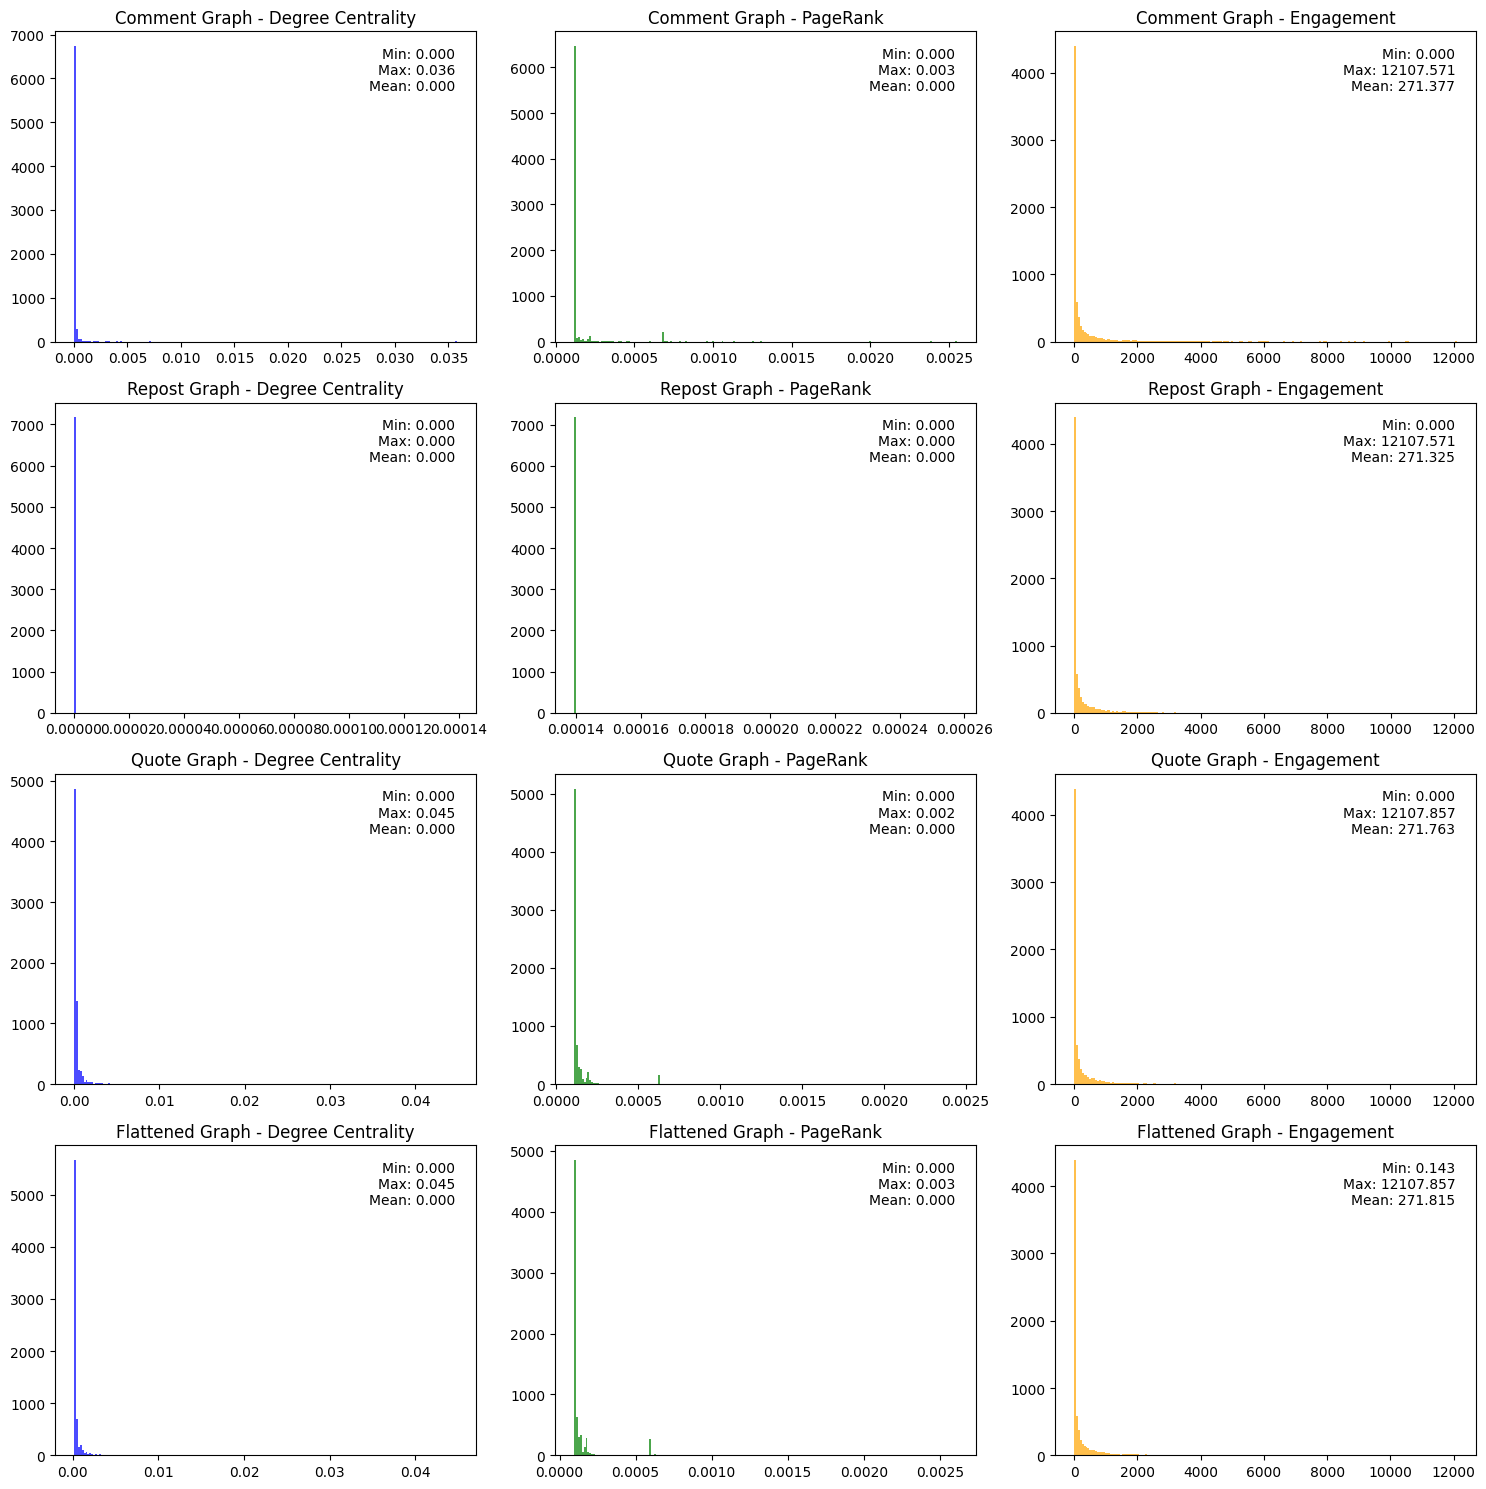

In [25]:
feed_graph_data = [
        ("Comment Graph", feed_comment_degree_centrality, feed_comment_pagerank, feed_comment_engagement),
        ("Repost Graph", feed_repost_degree_centrality, feed_repost_pagerank, feed_repost_engagement),
        ("Quote Graph", feed_quote_degree_centrality, feed_quote_pagerank, feed_quote_engagement),
        ("Flattened Graph", feed_flattened_degree_centrality, feed_flattened_pagerank, feed_flattened_engagement)
    ]

plot_distributions_with_stats(feed_graph_data)

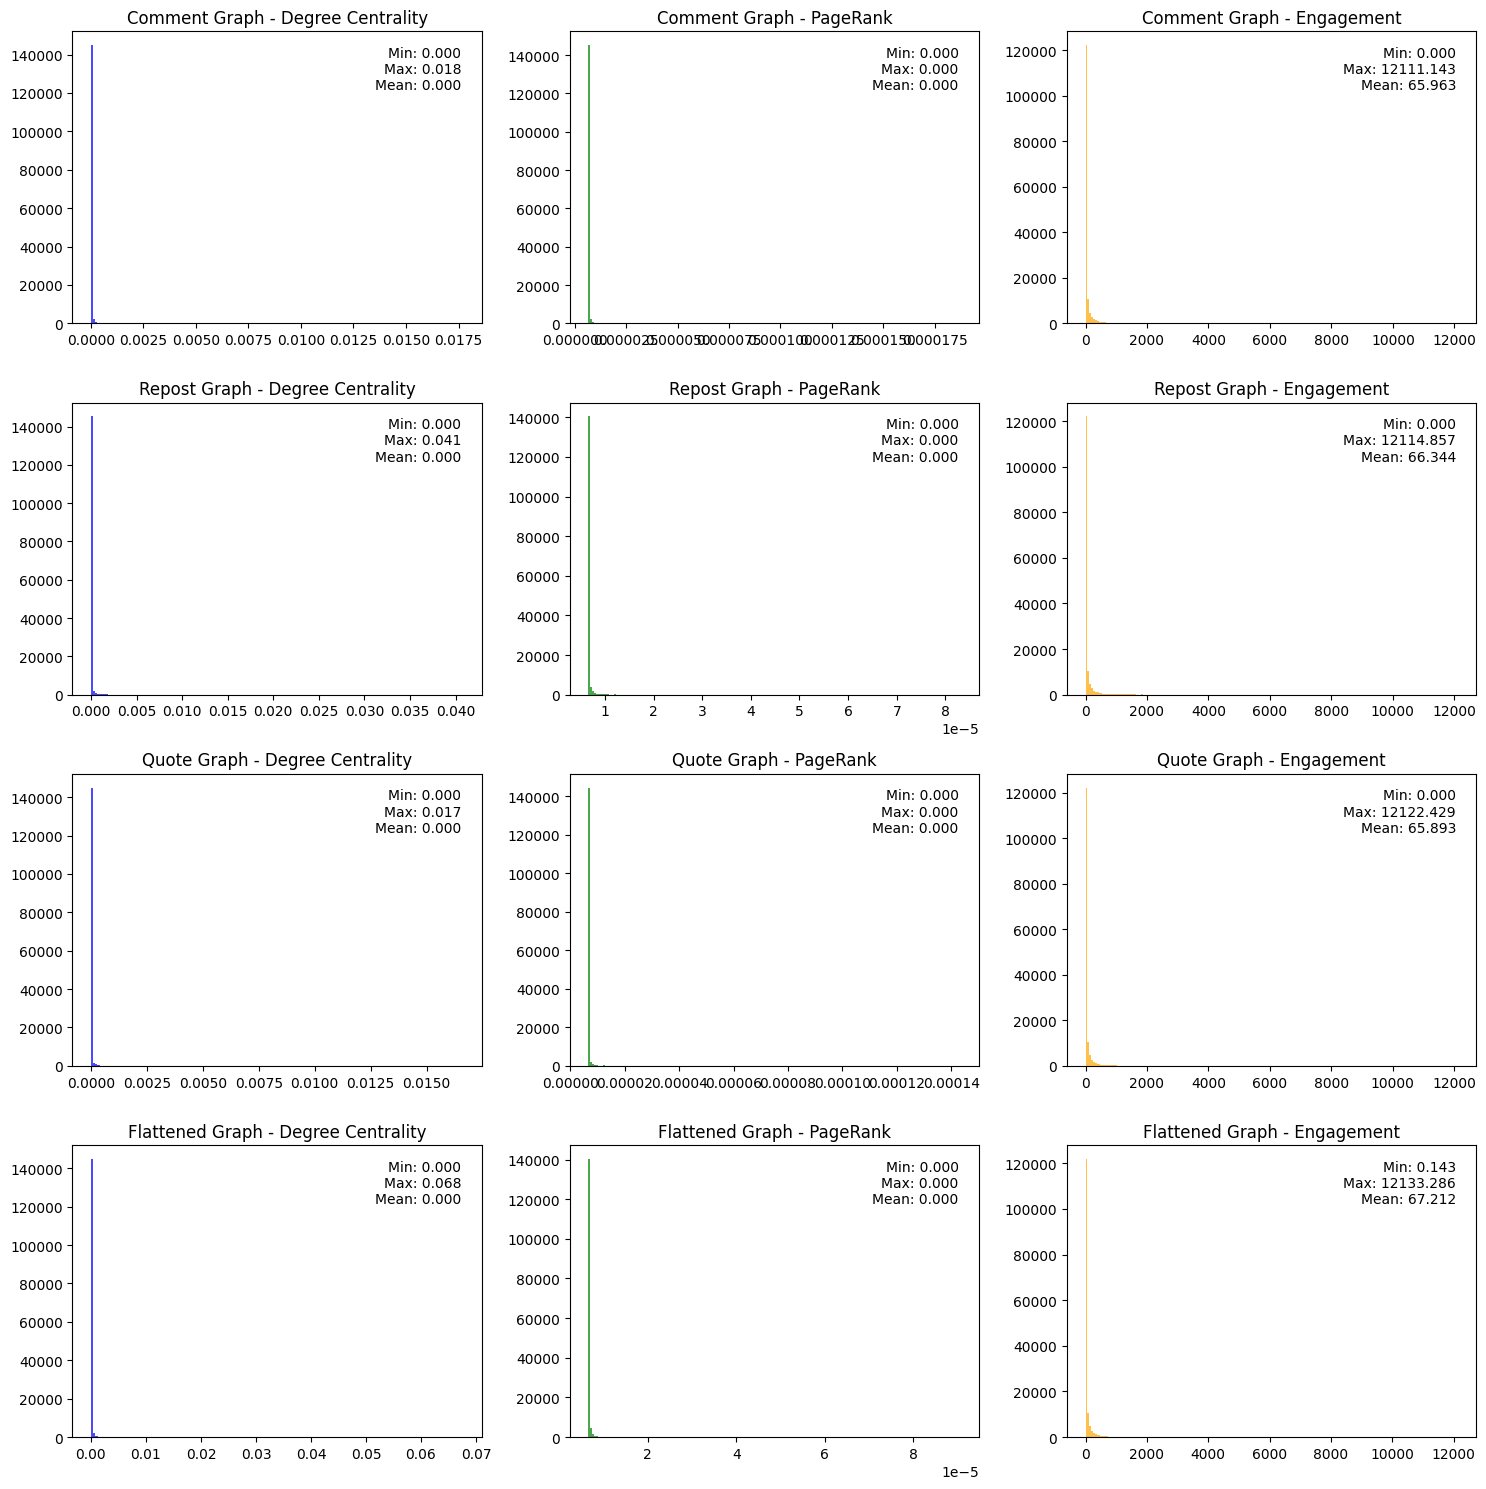

In [26]:
outside_graph_data = [
        ("Comment Graph", outside_comment_degree_centrality, outside_comment_pagerank, outside_comment_engagement),
        ("Repost Graph", outside_repost_degree_centrality, outside_repost_pagerank, outside_repost_engagement),
        ("Quote Graph", outside_quote_degree_centrality, outside_quote_pagerank, outside_quote_engagement),
        ("Flattened Graph", outside_flattened_degree_centrality, outside_flattened_pagerank, outside_flattened_engagement)
    ]

plot_distributions_with_stats(outside_graph_data)
